<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/Bidirectional_RNN_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [1]:
# ============================================
# 1. Install & Import Library
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import requests
import json
import random

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [2]:
# ============================================
# 2. Dataset Loaders
# ============================================

def load_imdb_dataset():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)
    x_train = pad_sequences(x_train, maxlen=200, padding='post', truncating='post')
    x_test = pad_sequences(x_test, maxlen=200, padding='post', truncating='post')
    return (x_train, y_train), (x_test, y_test)

def load_review_tokobaju_dataset():
    url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/1a62c814ab2a0a1c080e04391824de60a70e76e0/02.%20Deep%20Learning/05.%20Week%205/Datasets/ReviewTokoBaju.csv"
    df = pd.read_csv(url)
    df.columns = df.columns.str.strip()
    df = df.rename(columns={"Review Text": "review", "Recommended IND": "label"})

    vocab_size = 10000
    max_length = 100

    df['cleaned_review'] = df['review'].astype(str).str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)
    df = df[df['cleaned_review'].str.strip() != ""]

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="")
    tokenizer.fit_on_texts(df['cleaned_review'])
    sequences = tokenizer.texts_to_sequences(df['cleaned_review'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    labels = np.array(df['label'])
    X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42, stratify=labels)
    return (X_train, y_train), (X_test, y_test)

def load_deteksi_sarkasme_dataset():
    url = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"
    response = requests.get(url)
    if response.status_code == 200:
        data = [json.loads(line) for line in response.text.splitlines()]
        df = pd.DataFrame(data)
    else:
        raise Exception(f"Failed to load data: {response.status_code}")

    df = df[['headline', 'is_sarcastic']].dropna()

    vocab_size = 10000
    max_length = 30

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="")
    tokenizer.fit_on_texts(df['headline'])
    sequences = tokenizer.texts_to_sequences(df['headline'])
    padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    labels = df['is_sarcastic'].values
    X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42, stratify=labels)
    return (X_train, y_train), (X_test, y_test)

In [3]:
# ============================================
# 3. Utility Functions
# ============================================

def plot_training_history(history, title='Training History'):
    plt.figure(figsize=(14,5))

    # Plot Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [4]:
def calculate_metrics(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = (y_pred > 0.5).astype(int).reshape(-1)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1, "AUC-ROC": auc}

def build_birnn_model(vocab_size, embedding_dim, input_length, units=64, dropout_rate=0.5):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        Bidirectional(SimpleRNN(units)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
def random_search(train_data, test_data, trials=5):
    (x_train, y_train) = train_data
    (x_test, y_test) = test_data

    best_model = None
    best_acc = 0
    best_history = None

    for i in range(trials):
        embedding_dim = random.choice([64, 128])
        units = random.choice([32, 64, 128])
        dropout_rate = random.uniform(0.3, 0.5)
        learning_rate = random.choice([1e-3, 5e-4])
        batch_size = random.choice([32, 64])

        print(f"\nTrial {i+1}: hidden_units={units}, dropout={dropout_rate:.2f}, lr={learning_rate}\n")

        model = build_birnn_model(vocab_size=x_train.shape[1], embedding_dim=embedding_dim,
                                  input_length=x_train.shape[1], units=units, dropout_rate=dropout_rate)

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        history = model.fit(x_train, y_train, epochs=20, batch_size=batch_size,
                            validation_data=(x_test, y_test),
                            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                            verbose=1)

        acc = model.evaluate(x_test, y_test, verbose=0)[1]
        print(f"Validation Accuracy: {acc:.4f}\n")

        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_history = history

    best_model.history = best_history
    return best_model




======== IMDB Dataset ========


Trial 1: hidden_units=64, dropout=0.32, lr=0.001

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.5057 - loss: 0.7071 - val_accuracy: 0.5386 - val_loss: 0.6876
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.5271 - loss: 0.6944 - val_accuracy: 0.5575 - val_loss: 0.6815
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.5837 - loss: 0.6713 - val_accuracy: 0.5694 - val_loss: 0.6755
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - accuracy: 0.5858 - loss: 0.6730 - val_accuracy: 0.6014 - val_loss: 0.6678
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.5833 - loss: 0.6721 - val_accuracy: 0.5631 - val_loss: 0.6808
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.5835 - loss: 0.6707 - val_accuracy: 0.5864 - val_loss: 0.6704
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6071 - loss: 0.6656 - val_accuracy: 0.5098 - val_loss: 0.6923
Valid

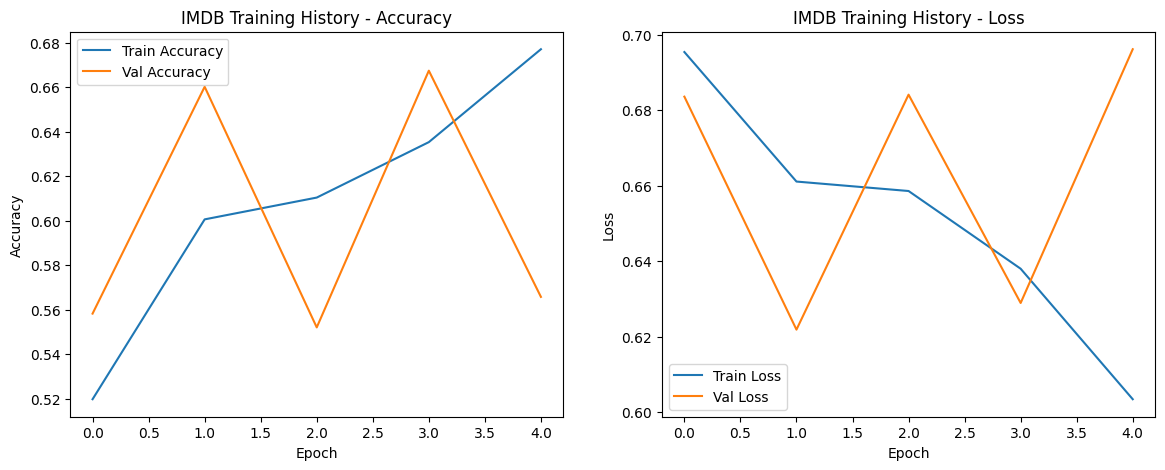

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step


In [8]:
# ============================================
# 4. Main Training per Dataset (Tanpa Loop)
# ============================================

# --- IMDB Dataset ---
print("\n\n======== IMDB Dataset ========\n")
(x_train, y_train), (x_test, y_test) = load_imdb_dataset()
best_model_imdb = random_search((x_train, y_train), (x_test, y_test))
plot_training_history(best_model_imdb.history, title='IMDB Training History')
metrics_imdb = calculate_metrics(best_model_imdb, x_test, y_test)



======== ReviewTokoBaju Dataset ========


Trial 1: hidden_units=128, dropout=0.42, lr=0.001

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


294/294 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.7818 - loss: 0.5269 - val_accuracy: 0.8223 - val_loss: 0.4718
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8128 - loss: 0.4837 - val_accuracy: 0.8178 - val_loss: 0.4216
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8186 - loss: 0.4293 - val_accuracy: 0.8250 - val_loss: 0.4064
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8175 - loss: 0.4346 - val_accuracy: 0.8276 - val_loss: 0.3969
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8199 - loss: 0.4150 - val_accuracy: 0.8216 - val_loss: 0.4594
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8186 - loss: 0.4723 - val_accuracy: 0.8210 - val_loss: 0.4451
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8189 - loss: 0.4504 - val_accuracy: 0.8206 - val_loss: 0.4069
Validation Accuracy: 0.8276


Trial 2: hidden_units=64, dropout=0.38, lr=0.001

Epoch 1/20
294/294 ━━━━━

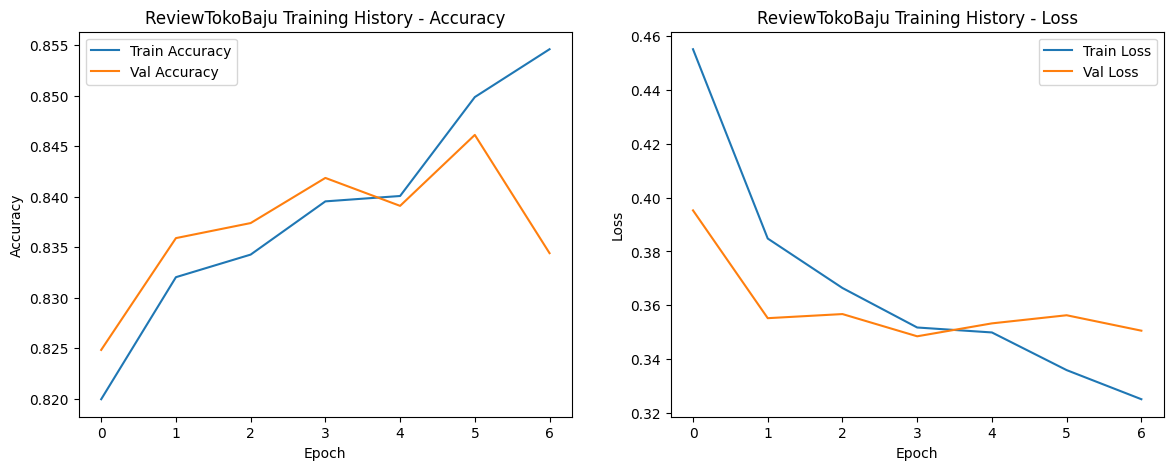

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [9]:
# --- Review Toko Baju Dataset ---
print("\n\n======== ReviewTokoBaju Dataset ========\n")
(x_train, y_train), (x_test, y_test) = load_review_tokobaju_dataset()
best_model_tokobaju = random_search((x_train, y_train), (x_test, y_test))
plot_training_history(best_model_tokobaju.history, title='ReviewTokoBaju Training History')
metrics_tokobaju = calculate_metrics(best_model_tokobaju, x_test, y_test)



======== Deteksi Sarkasme Dataset ========


Trial 1: hidden_units=32, dropout=0.48, lr=0.001

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


716/716 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6342 - loss: 0.6140 - val_accuracy: 0.7170 - val_loss: 0.5269
Epoch 2/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7140 - loss: 0.5361 - val_accuracy: 0.7095 - val_loss: 0.5362
Epoch 3/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7148 - loss: 0.5338 - val_accuracy: 0.7205 - val_loss: 0.5230
Epoch 4/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7139 - loss: 0.5319 - val_accuracy: 0.7179 - val_loss: 0.5279
Epoch 5/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7169 - loss: 0.5251 - val_accuracy: 0.7193 - val_loss: 0.5232
Epoch 6/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7183 - loss: 0.5258 - val_accuracy: 0.7170 - val_loss: 0.5241
Validation Accuracy: 0.7205


Trial 2: hidden_units=32, dropout=0.35, lr=0.0005

Epoch 1/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6390 - loss: 0.6128 - val_accuracy: 0.7100 - val_loss: 0.5462
Epoch 2/20
716/716 ━━━━━━━━━━━

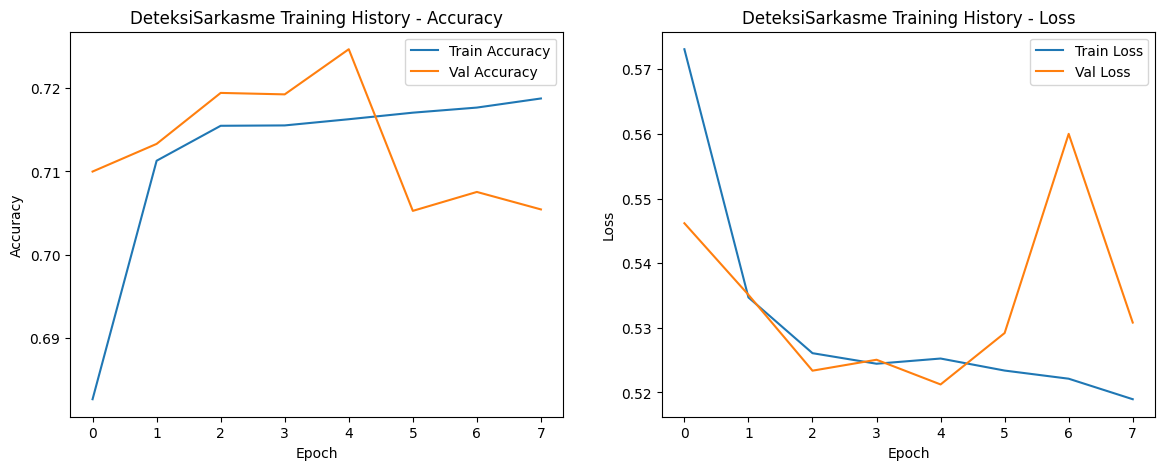

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [10]:
# --- Deteksi Sarkasme Dataset ---
print("\n\n======== Deteksi Sarkasme Dataset ========\n")
(x_train, y_train), (x_test, y_test) = load_deteksi_sarkasme_dataset()
best_model_sarkasme = random_search((x_train, y_train), (x_test, y_test))
plot_training_history(best_model_sarkasme.history, title='DeteksiSarkasme Training History')
metrics_sarkasme = calculate_metrics(best_model_sarkasme, x_test, y_test)

In [11]:
# ============================================
# 5. Final Comparative Analysis
# ============================================
final_results = pd.DataFrame({
    "Dataset": ["IMDB", "ReviewTokoBaju", "DeteksiSarkasme"],
    "Accuracy": [metrics_imdb["Accuracy"], metrics_tokobaju["Accuracy"], metrics_sarkasme["Accuracy"]],
    "Precision": [metrics_imdb["Precision"], metrics_tokobaju["Precision"], metrics_sarkasme["Precision"]],
    "Recall": [metrics_imdb["Recall"], metrics_tokobaju["Recall"], metrics_sarkasme["Recall"]],
    "F1-Score": [metrics_imdb["F1-Score"], metrics_tokobaju["F1-Score"], metrics_sarkasme["F1-Score"]],
    "AUC-ROC": [metrics_imdb["AUC-ROC"], metrics_tokobaju["AUC-ROC"], metrics_sarkasme["AUC-ROC"]]
})

print("\n\n======== Final Results ========\n")
display(final_results)



======== Final Results ========



,Dataset,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,IMDB,0.660240,0.666473,0.641520,0.653758,0.660240
1,ReviewTokoBaju,0.841848,0.873206,0.944862,0.907622,0.655065
2,DeteksiSarkasme,0.724668,0.684870,0.781812,0.730137,0.727242
